دانلود دیتاست مورد استفاده:   https://www.mediafire.com/file/j03djpy140rno4d/data.rar/file

* کتابخانه ها

In [35]:
import os  
import numpy as np  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from PIL import Image  
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

* ورود دیتاست

In [36]:
data_dir = "data"  
categories = os.listdir(data_dir)  
image_size = (32, 32)  # اندازه تصاویر  
num_classes = len(categories)  

valid_formats = ('.jpg', '.png', '.gif', '.jpeg')

print(f'Number_Classes : {num_classes}')

Number_Classes : 3


* شمارش تعداد تصاویر و فرمت های موجود

In [37]:
for category in categories:  
    category_path = os.path.join(data_dir, category)
    image_count = len([file for file in os.listdir(category_path) 
                       if file.lower().endswith(valid_formats)])
    print(f"Number_Images_{category} : {image_count} images.")

print(f"\n")

for category in categories:
    category_path = os.path.join(data_dir, category)
    format_count = {ext: 0 for ext in valid_formats}
    
    for file in os.listdir(category_path):
        file_lower = file.lower()
        for ext in valid_formats:
            if file_lower.endswith(ext):
                format_count[ext] += 1

    print(f"Emotion: {category} ")
    for ext, count in format_count.items():
        print(f"                 {ext}: {count}  ")

Number_Images_Angry : 86 images.
Number_Images_Happy : 100 images.
Number_Images_Sad : 79 images.


Emotion: Angry 
                 .jpg: 67  
                 .png: 14  
                 .gif: 0  
                 .jpeg: 5  
Emotion: Happy 
                 .jpg: 80  
                 .png: 8  
                 .gif: 0  
                 .jpeg: 12  
Emotion: Sad 
                 .jpg: 69  
                 .png: 4  
                 .gif: 1  
                 .jpeg: 5  


* بارگذاری داده ها

In [38]:
# بارگذاری داده‌ها
def load_data(data_dir, categories, valid_formats, img_size):
    images = []
    labels = []
    img_size = 32  # تصویر برای تغییر سایز

    for label, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        for file in os.listdir(category_path):
            if file.lower().endswith(valid_formats):
                file_path = os.path.join(category_path, file)
                try:
                    if file.lower().endswith('.gif'):
                        img = Image.open(file_path)
                        img = img.convert('RGB')  # تبدیل به RGB
                        img_resized = img.resize((img_size, img_size), Image.LANCZOS)  # تغییر اندازه با آنتی‌الیزینگ
                        img_resized = cv2.cvtColor(np.array(img_resized), cv2.COLOR_RGB2BGR)  # تبدیل به OpenCV
                    else:
                        img = cv2.imread(file_path, cv2.IMREAD_COLOR)  # بارگذاری سایر تصاویر با OpenCV
                        if img is not None:
                            img_resized = cv2.resize(img, (img_size, img_size))

                    img_array = np.array(img_resized) / 255.0  # نرمال‌سازی
                    img_array = img_array.flatten()  # تبدیل به آرایه 1 بعدی

                    images.append(img_array)  # اضافه کردن تصویر تغییر اندازه داده شده
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(images), np.array(labels)

# بارگذاری داده‌ها  
images, labels = load_data(data_dir, categories, valid_formats, image_size)  

* تقسیم داده‌ها به آموزشی و آزمایشی 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, 
                                                    test_size=0.2, random_state=42)


* تبدیل به tensor

In [40]:
X_train = torch.tensor(X_train, dtype=torch.float32)  
X_test = torch.tensor(X_test, dtype=torch.float32)  
y_train = torch.tensor(y_train, dtype=torch.long)  
y_test = torch.tensor(y_test, dtype=torch.long)

*  مدل EmotionRNN

In [41]:
class EmotionRNN(nn.Module):  
    def __init__(self, input_size, hidden_size, num_classes):  
        super(EmotionRNN, self).__init__()  
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)  
        self.fc = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):  
        # x باید به شکل (batch_size, sequence_length, input_size) باشد  
        out, _ = self.rnn(x)  # out شکل (batch_size, sequence_length, hidden_size)  
        out = self.fc(out[:, -1, :])  # فقط آخرین خروجی را می‌گیریم  
        return out  

* پارامترهای مدل

In [42]:
input_size = X_train.shape[1]  # تعداد ویژگی‌ها (پیکسل‌ها)  
hidden_size = 128  # تعداد نرون‌ها در لایه مخفی  
learning_rate = 0.001

In [43]:
model = EmotionRNN(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

* بهینه سازی
* *optimizer *

In [44]:
optimizer = optim.Adam(model.parameters(), learning_rate)  
criterion = nn.CrossEntropyLoss()  # استفاده از CrossEntropy برای مسائل طبقه‌بندی

* تغییر شکل داده ها

In [45]:
#(batch_size, sequence_length, input_size)  
sequence_length = 1  # برای هر تصویر یک توالی داریم  
X_train = X_train.view(-1, sequence_length, input_size)  
X_test = X_test.view(-1, sequence_length, input_size)

In [46]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([212, 1, 3072])
y_train shape: torch.Size([212])


* تغییر device

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EmotionRNN(
  (rnn): RNN(3072, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

* آموزش مدل

In [48]:
# آموزش مدل
num_epochs = 100  # تعداد دوره‌های آموزش
for epoch in range(num_epochs):
    model.train()  # تنظیم مدل برای حالت آموزش
    optimizer.zero_grad()  # صفر کردن گرادیان‌های قبلی
    
    # پیش‌بینی خروجی مدل
    outputs = model(X_train.to(device))  
    loss = criterion(outputs, y_train.to(device))  # محاسبه خطا (زیان)
    
    loss.backward()  # محاسبه گرادیان‌ها
    optimizer.step()  # به‌روزرسانی وزن‌ها با استفاده از optimizer

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 1.1770
Epoch [2/100], Loss: 1.5447
Epoch [3/100], Loss: 1.3279
Epoch [4/100], Loss: 1.1075
Epoch [5/100], Loss: 1.0297
Epoch [6/100], Loss: 1.0455
Epoch [7/100], Loss: 1.0329
Epoch [8/100], Loss: 1.0095
Epoch [9/100], Loss: 0.9870
Epoch [10/100], Loss: 0.9736
Epoch [11/100], Loss: 0.9646
Epoch [12/100], Loss: 0.9510
Epoch [13/100], Loss: 0.9391
Epoch [14/100], Loss: 0.9269
Epoch [15/100], Loss: 0.9102
Epoch [16/100], Loss: 0.8917
Epoch [17/100], Loss: 0.8783
Epoch [18/100], Loss: 0.8661
Epoch [19/100], Loss: 0.8564
Epoch [20/100], Loss: 0.8421
Epoch [21/100], Loss: 0.8254
Epoch [22/100], Loss: 0.8047
Epoch [23/100], Loss: 0.7929
Epoch [24/100], Loss: 0.7811
Epoch [25/100], Loss: 0.7665
Epoch [26/100], Loss: 0.7501
Epoch [27/100], Loss: 0.7344
Epoch [28/100], Loss: 0.7200
Epoch [29/100], Loss: 0.7084
Epoch [30/100], Loss: 0.6937
Epoch [31/100], Loss: 0.6770
Epoch [32/100], Loss: 0.6631
Epoch [33/100], Loss: 0.6481
Epoch [34/100], Loss: 0.6335
Epoch [35/100], Loss: 0

* ارزیابی مدل

In [49]:
model.eval()  
with torch.no_grad():  
    test_outputs = model(X_test.to(device))  
    _, predicted = torch.max(test_outputs, 1)  
    test_accuracy = (predicted == y_test.to(device)).float().mean()  
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Test Accuracy: 62.26%


* پیش بینی تابع

In [50]:
def predict_emotion(model, image_path):  
    img = Image.open(image_path)  
    original_size = img.size  # Store the original size for later use  
    img = img.convert('RGB')  
    img_resized = img.resize((image_size[0], image_size[1]), Image.LANCZOS)  
    img_array = cv2.cvtColor(np.array(img_resized), cv2.COLOR_RGB2BGR) / 255.0  
    img_array = img_array.reshape(1, 1, image_size[0] * image_size[1] * 3)  # Reshape for RNN  

    img_tensor = torch.tensor(img_array, dtype=torch.float32).to(device)  
    
    # پیش بینی  
    model.eval()  
    with torch.no_grad():  
        prediction = model(img_tensor)  
        predicted_class = torch.argmax(prediction, axis=1).item()  
        emotion_name = categories[predicted_class]  

    # نمایش تصویر با پیش‌ بینی احساس
    plt.imshow(img)  
    plt.title(f'Predicted Emotion: {emotion_name}')  
    plt.axis('off')  
    plt.show()  
    
    return emotion_name



* عکس از دیتاست آموزشی

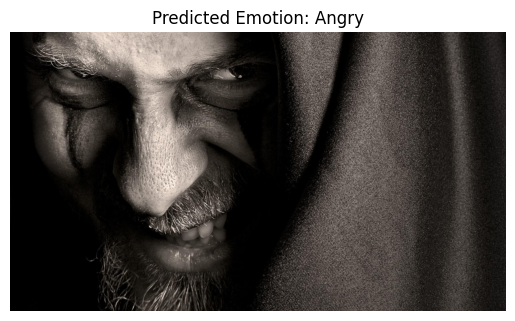

In [51]:
image_path = "H:/codes/project_1403/data/Angry/3710928.jpg"  
predicted_emotion = predict_emotion(model, image_path)  
#print(f'Predicted Emotion: {predicted_emotion}')

* عکس خارج از دیتاست آموزشی

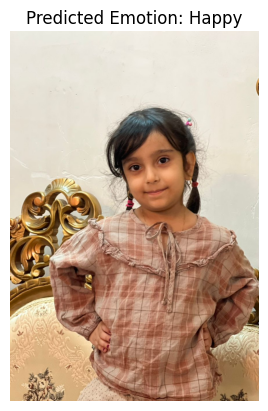

In [52]:
image_path = "H:/codes/project_1403/aras/_5.jpeg"   
predicted_emotion = predict_emotion(model, image_path)  
#print(f'Predicted Emotion: {predicted_emotion}')